# Project Part 3: Tweets Tokens Visualization

## Term Frequency
Before I move on to the sentiment analysis, I hope to realize what are the tokens most commonly used and how different the tokens in two different classes (pre-event, after-event). 

The sklearn.CountVectorizer converts a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. There are parameter options available for count vectorizer, such as removing stop-words or limiting the maximum number of terms. 

In [1]:
import os
os.chdir('C:\\Users\\yaffy\\Desktop\\python')
import pandas as pd
import numpy as np

my_df_liverp = pd.read_csv('clean_liverp.csv')
my_df_liverp.head()

my_df_liverp = my_df_liverp[my_df_liverp.period != 'post-event-week2']
my_df_liverp = my_df_liverp[my_df_liverp.period != 'post-event-week3']
my_df_liverp['period'] = my_df_liverp['period'].map({'pre-event': 'pre', 'mid-event': 'post', 'post-event-week1':'post'})
my_df_liverp = my_df_liverp.dropna(subset=['clean_text'], how = 'all')

my_df_liverp.to_csv('new_clean_liverp.csv')

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000) # consider the top 10,000 tokens ordered by term frequency 
cvec.fit(my_df_liverp.clean_text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [3]:
pre_doc_matrix = cvec.transform(my_df_liverp[my_df_liverp.period == 'pre'].clean_text)
post_doc_matrix = cvec.transform(my_df_liverp[my_df_liverp.period == 'post'].clean_text)

pre_tf = np.sum(pre_doc_matrix,axis=0)
post_tf = np.sum(post_doc_matrix,axis=0)

pre = np.squeeze(np.asarray(pre_tf))
post = np.squeeze(np.asarray(post_tf))

term_freq_df = pd.DataFrame([pre,post],columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ['pre', 'post']
term_freq_df['total'] = term_freq_df['pre'] + term_freq_df['post']
term_freq_df.sort_values(by = 'total', ascending=False).iloc[:10]

,pre,post,total
liverpool,929,5357,6286
win,630,3385,4015
fans,627,3192,3819
good,480,3323,3803
final,921,2379,3300
like,423,2829,3252
team,312,2860,3172
season,173,2935,3108
come,337,2575,2912
karius,9,2886,2895


In order to come up with a meaningful metric which can characterise important tokens in each category, Kessler (2017) presented a Python library called Scattertext. The metrics used in the Scattertext as a way of visualising text data are very useful to filter meaningful tokens from the frequency data. 

Take harmonic mean of pre-rate and pre-frequent-percentage (both have to be high). 

- If a word appears more often in a class compared to another, this can be a good measure of how much the word is meaningful to the characterised class. 


\begin{equation*}
pre\; rate = \frac{pre\; frequency}{pre\; frequency + post\; frequence}
\end{equation*}

- Similarly, define the frequency a word occurs in the class as:

\begin{equation*}
pre\; freq\; pct = \frac{pre\; frequency}{\sum pre\; frequency}
\end{equation*}

- Since the pre_rate has much wider range (from 0 - 1), if we average these two values, pre_rate will be too dominant, and will not reflect both metrics accuratly. Using harmonic mean defined as: 
\begin{equation*}
H = \frac {n}{\sum_{i=1}^{n}\ \frac{1}{x_i}}
\end{equation*}


Since the harmonic means are dominated by the pre_freq_pct, take the normal CDF of pre_rate and pre_freq_pct, which will fall between 0 - 1, which scales and standardizes both scores. CDF can be explained as 'distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x'. In the below result of code, we can see a word 'tomorrow' with pre-rate_normcdf of 0.999065, and pre_freq_pct_normcdf of 1.000000, This means roughly 99.9% tokens will take a pre_rate less than or equal to 0.850932, and 100% will take a pre_freq_pct value less than or equal to 0.016520. 

Calculate the harmonic mean of these two CDF values, we can see that pre_normcdf_hmean metric provides a more meaningful measure of how important a word is within the class. 

In [4]:
from scipy.stats import hmean
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df['pre_rate'] = term_freq_df['pre'] * 1./term_freq_df['total']
term_freq_df['pre_freq_pct'] = term_freq_df['pre'] * 1./term_freq_df['pre'].sum()
term_freq_df['pre_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pre_rate'], x['pre_freq_pct']])
                                                                if x['pre_rate'] > 0 and x['pre_freq_pct'] > 0 
                                                               else 0), axis=1)                                                        
term_freq_df['pre_rate_normcdf'] = normcdf(term_freq_df['pre_rate'])
term_freq_df['pre_freq_pct_normcdf'] = normcdf(term_freq_df['pre_freq_pct'])
term_freq_df['pre_normcdf_hmean'] = hmean([term_freq_df['pre_rate_normcdf'], term_freq_df['pre_freq_pct_normcdf']])
term_freq_df.sort_values(by='pre_normcdf_hmean', ascending=False).iloc[:10]

,pre,post,total,pre_rate,pre_freq_pct,pre_hmean,pre_rate_normcdf,pre_freq_pct_normcdf,pre_normcdf_hmean
flights,137,24,161,0.850932,0.001946,0.003883,0.999873,0.999994,0.999934
tomorrow,588,198,786,0.748092,0.008352,0.016520,0.999065,1.000000,0.999532
saturday,428,169,597,0.716918,0.006079,0.012057,0.998379,1.000000,0.999189
flight,106,39,145,0.731034,0.001506,0.003005,0.998733,0.999590,0.999161
axelrod,88,16,104,0.846154,0.001250,0.002496,0.999860,0.996906,0.998381
cancelled,89,29,118,0.754237,0.001264,0.002524,0.999164,0.997210,0.998186
ticket,95,72,167,0.568862,0.001349,0.002692,0.984357,0.998532,0.991394
kiev,471,412,883,0.533409,0.006690,0.013215,0.975245,1.000000,0.987467
brody,65,6,71,0.915493,0.000923,0.001845,0.999969,0.974995,0.987324
joe,78,63,141,0.553191,0.001108,0.002211,0.980763,0.991791,0.986246


In [5]:
term_freq_df['post_rate'] = term_freq_df['post'] * 1./term_freq_df['total']
term_freq_df['post_freq_pct'] = term_freq_df['post'] * 1./term_freq_df['pre'].sum()
term_freq_df['post_hmean'] = term_freq_df.apply(lambda x: (hmean([x['post_rate'], x['post_freq_pct']])
                                                                if x['post_rate'] > 0 and x['post_freq_pct'] > 0 
                                                                else 0), axis=1)                                                        
term_freq_df['post_rate_normcdf'] = normcdf(term_freq_df['post_rate'])
term_freq_df['post_freq_pct_normcdf'] = normcdf(term_freq_df['post_freq_pct'])
term_freq_df['post_normcdf_hmean'] = hmean([term_freq_df['post_rate_normcdf'], term_freq_df['post_freq_pct_normcdf']])
term_freq_df.sort_values(by='post_normcdf_hmean', ascending=False).iloc[:10]

,pre,post,total,pre_rate,pre_freq_pct,pre_hmean,pre_rate_normcdf,pre_freq_pct_normcdf,pre_normcdf_hmean,post_rate,post_freq_pct,post_hmean,post_rate_normcdf,post_freq_pct_normcdf,post_normcdf_hmean
fabinho,0,1975,1975,0.000000,0.000000,0.000000,0.188533,0.405917,0.257477,1.000000,0.028053,0.054575,0.811467,1.000000,0.895922
oblak,1,697,698,0.001433,0.000014,0.000028,0.190605,0.419080,0.262033,0.998567,0.009900,0.019606,0.809395,0.999915,0.894624
mistakes,2,983,985,0.002030,0.000028,0.000056,0.191474,0.432335,0.265405,0.997970,0.013963,0.027540,0.808526,1.000000,0.894127
loris,0,495,495,0.000000,0.000000,0.000000,0.188533,0.405917,0.257477,1.000000,0.007031,0.013964,0.811467,0.995333,0.894045
keeper,5,1622,1627,0.003073,0.000071,0.000139,0.192996,0.472499,0.274053,0.996927,0.023039,0.045037,0.807004,1.000000,0.893196
karius,9,2886,2895,0.003109,0.000128,0.000246,0.193048,0.526418,0.282498,0.996891,0.040993,0.078748,0.806952,1.000000,0.893164
goalkeeper,5,1343,1348,0.003709,0.000071,0.000139,0.193927,0.472499,0.274991,0.996291,0.019076,0.037436,0.806073,1.000000,0.892625
stronger,2,528,530,0.003774,0.000028,0.000056,0.194022,0.432335,0.267842,0.996226,0.007500,0.014887,0.805978,0.997358,0.891513
keita,2,468,470,0.004255,0.000028,0.000056,0.194729,0.432335,0.268516,0.995745,0.006648,0.013207,0.805271,0.992746,0.889235
alisson,3,449,452,0.006637,0.000043,0.000085,0.198251,0.445666,0.274426,0.993363,0.006378,0.012674,0.801749,0.990236,0.886079


## Scatter Text

Visualzing term associations, that is, what words and phrases are more characteristic of a category than others. Making the y-axis category 'post-event' and named it as 'Liverpool Post-event'. The other category 'pre-event' will be named as 'Liverpool Pre-event'. I set the width of visualization in pixels, and label each excerpt with 'period' using the metadata parameter. 

In [5]:
from __future__ import unicode_literals
import scattertext as st
import spacy
from pprint import pprint

import en_core_web_sm
nlp = en_core_web_sm.load()

In [25]:
convention_df = pd.read_csv('new_clean_liverp.csv', encoding='utf-8') 
convention_df['parsed'] = convention_df.clean_text.apply(nlp)

Turn the dataframe into a Scattertext Corpus to look for differences in periods. Pass a spaCy model into the nlp argument and call build() to construct the corpus. 

It's a relatively simple visualization of word use during the 2018 UEFA Real Madrid vs Liverpool. Each dot corresponds to a word or phrase mentioned by Liverpool supporters. The closer a dot is to the top of the plot, the more frequently it was used before the event. The further the right a dot, the more that the word or phrase used at post-event. Words frequently used by both periods, such as 'win', 'liverpool', 'madrid' tend to occur in the upper-right-hand corner. 

Look at upper-left and lower-right corner, the words like 'tomorrow night', 'goosebumps', 'satursday', 'joe' are frequently used before the game but infrequently or never used at post-game. Likewise, terms frequently used at post-game and infrequently at pre-event occupy the bottom-right corner. Such as 'mistakes', 'threats', 'dirty' after losing the Champions League Final. 

Terms are colored by their association. Those that are more associated with 'pre-event' are blue, and those are associated with 'post-event' are red. Terms are most characteristic of both sets of documents are displayed on the far-right corner. 

In [27]:
convention_df = pd.read_csv('convention_clean_liverp.csv', encoding = 'utf-8')
corpus = st.CorpusFromPandas(convention_df, category_col = 'period', text_col = 'clean_text', nlp=nlp).build()

In [30]:
html = st.produce_scattertext_explorer(corpus,
                                       category = 'pre',
                                       category_name = 'Liverpool Pre-event',
                                       not_category_name = 'Liverpool Post-event',
                                       minimum_term_frequency = 50, # omit terms that occur less than 50 times
                                       width_in_pixels = 1000,
                                       metadata = convention_df['period'])

f = open('Liverpool.html', 'w')
f.write(html.encode('utf-8'))
f.close()

import webbrowser
webbrowser.open_new_tab('Liverpool.html')

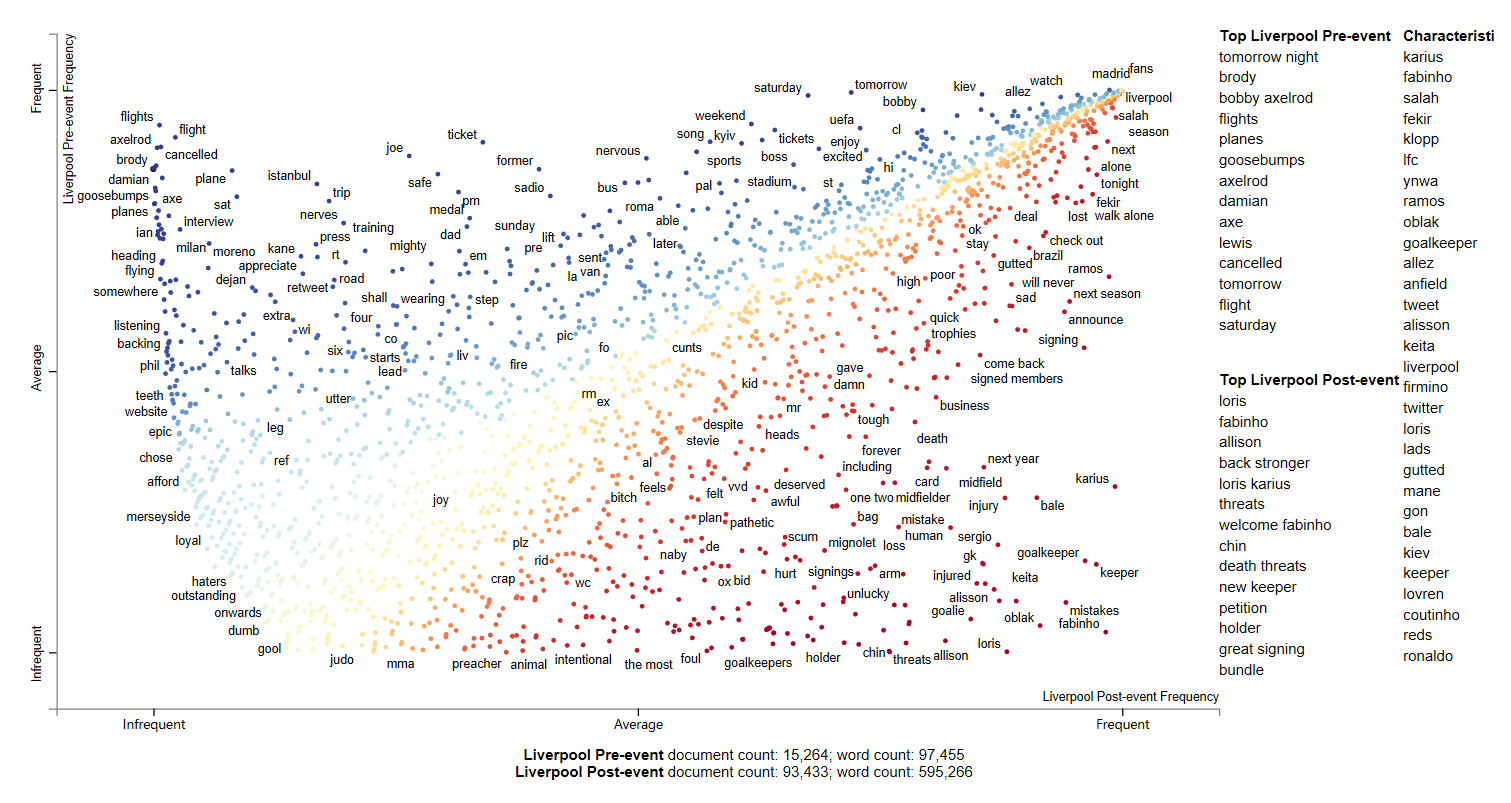

In [35]:
from IPython.display import Image
Image(filename='Liverpool.png')

Apply the same calculation to Real Madrid dateset

In [33]:
my_df_madrid = pd.read_csv('clean_madrid.csv')
my_df_madrid.head()

my_df_madrid = my_df_madrid[my_df_madrid.period != 'post-event-week2']
my_df_madrid = my_df_madrid[my_df_madrid.period != 'post-event-week3']
my_df_madrid['period'] = my_df_madrid['period'].map({'pre-event': 'pre', 'mid-event': 'post', 'post-event-week1':'post'})
my_df_madrid = my_df_madrid.dropna(subset=['clean_text'], how = 'all')

my_df_madrid.to_csv('new_clean_madrid.csv')

cvec = CountVectorizer(stop_words='english',max_features=10000) # consider the top 10,000 tokens ordered by term frequency 
cvec.fit(my_df_madrid.clean_text)

pre_doc_matrix = cvec.transform(my_df_madrid[my_df_madrid.period == 'pre'].clean_text)
post_doc_matrix = cvec.transform(my_df_madrid[my_df_madrid.period == 'post'].clean_text)

pre_tf = np.sum(pre_doc_matrix,axis=0)
post_tf = np.sum(post_doc_matrix,axis=0)

pre = np.squeeze(np.asarray(pre_tf))
post = np.squeeze(np.asarray(post_tf))

term_freq_df = pd.DataFrame([pre,post],columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ['pre', 'post']
term_freq_df['total'] = term_freq_df['pre'] + term_freq_df['post']

term_freq_df['pre_rate'] = term_freq_df['pre'] * 1./term_freq_df['total']
term_freq_df['pre_freq_pct'] = term_freq_df['pre'] * 1./term_freq_df['pre'].sum()
term_freq_df['pre_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pre_rate'], x['pre_freq_pct']])
                                                                if x['pre_rate'] > 0 and x['pre_freq_pct'] > 0 
                                                               else 0), axis=1)                                                        
term_freq_df['pre_rate_normcdf'] = normcdf(term_freq_df['pre_rate'])
term_freq_df['pre_freq_pct_normcdf'] = normcdf(term_freq_df['pre_freq_pct'])
term_freq_df['pre_normcdf_hmean'] = hmean([term_freq_df['pre_rate_normcdf'], term_freq_df['pre_freq_pct_normcdf']])
term_freq_df.sort_values(by='pre_normcdf_hmean', ascending=False).iloc[:10]

,pre,post,total,pre_rate,pre_freq_pct,pre_hmean,pre_rate_normcdf,pre_freq_pct_normcdf,pre_normcdf_hmean
tomorrow,134,41,175,0.765714,0.011843,0.023325,0.995512,1.000000,0.997751
saturday,93,30,123,0.756098,0.008219,0.016262,0.994979,1.000000,0.997483
perry,14,2,16,0.875000,0.001237,0.002471,0.998860,0.986330,0.992555
preview,16,8,24,0.666667,0.001414,0.002822,0.986651,0.994607,0.990613
cars,12,0,12,1.000000,0.001061,0.002119,0.999809,0.968817,0.984069
boot,12,1,13,0.923077,0.001061,0.002119,0.999410,0.968817,0.983876
innovation,11,0,11,1.000000,0.000972,0.001942,0.999809,0.954697,0.976732
textile,11,0,11,1.000000,0.000972,0.001942,0.999809,0.954697,0.976732
sportwear,11,0,11,1.000000,0.000972,0.001942,0.999809,0.954697,0.976732
vehicles,11,0,11,1.000000,0.000972,0.001942,0.999809,0.954697,0.976732


In [34]:
term_freq_df['post_rate'] = term_freq_df['post'] * 1./term_freq_df['total']
term_freq_df['post_freq_pct'] = term_freq_df['post'] * 1./term_freq_df['pre'].sum()
term_freq_df['post_hmean'] = term_freq_df.apply(lambda x: (hmean([x['post_rate'], x['post_freq_pct']])
                                                                if x['post_rate'] > 0 and x['post_freq_pct'] > 0 
                                                                else 0), axis=1)                                                        
term_freq_df['post_rate_normcdf'] = normcdf(term_freq_df['post_rate'])
term_freq_df['post_freq_pct_normcdf'] = normcdf(term_freq_df['post_freq_pct'])
term_freq_df['post_normcdf_hmean'] = hmean([term_freq_df['post_rate_normcdf'], term_freq_df['post_freq_pct_normcdf']])
term_freq_df.sort_values(by='post_normcdf_hmean', ascending=False).iloc[:10]

,pre,post,total,pre_rate,pre_freq_pct,pre_hmean,pre_rate_normcdf,pre_freq_pct_normcdf,pre_normcdf_hmean,post_rate,post_freq_pct,post_hmean,post_rate_normcdf,post_freq_pct_normcdf,post_normcdf_hmean
karius,0,232,232,0.000000,0.000000,0.000000,0.324025,0.423078,0.366985,1.000000,0.020504,0.040184,0.675975,1.000000,0.806665
congratulations,4,818,822,0.004866,0.000354,0.000659,0.331067,0.688597,0.447151,0.995134,0.072293,0.134794,0.668933,1.000000,0.801629
congrats,3,494,497,0.006036,0.000265,0.000508,0.332770,0.625668,0.434464,0.993964,0.043659,0.083644,0.667230,1.000000,0.800406
dirty,1,158,159,0.006289,0.000088,0.000174,0.333139,0.491005,0.396952,0.993711,0.013964,0.027541,0.666861,0.999735,0.800055
announce,1,148,149,0.006711,0.000088,0.000174,0.333754,0.491005,0.397388,0.993289,0.013080,0.025820,0.666246,0.999384,0.799500
cunt,0,95,95,0.000000,0.000000,0.000000,0.324025,0.423078,0.366985,1.000000,0.008396,0.016652,0.675975,0.976874,0.799036
breaking,0,92,92,0.000000,0.000000,0.000000,0.324025,0.423078,0.366985,1.000000,0.008131,0.016130,0.675975,0.972759,0.797656
twitter,1,121,122,0.008197,0.000088,0.000175,0.335923,0.491005,0.398922,0.991803,0.010694,0.021159,0.664077,0.995347,0.796647
wenger,3,303,306,0.009804,0.000265,0.000516,0.338275,0.625668,0.439130,0.990196,0.026779,0.052147,0.661725,1.000000,0.796431
mark,0,88,88,0.000000,0.000000,0.000000,0.324025,0.423078,0.366985,1.000000,0.007777,0.015435,0.675975,0.966339,0.795489


In [36]:
convention_df = pd.read_csv('new_clean_madrid.csv', encoding='utf-8') 
convention_df['parsed'] = convention_df.clean_text.apply(nlp)

corpus = st.CorpusFromPandas(convention_df, category_col = 'period', text_col = 'clean_text', nlp=nlp).build()

html = st.produce_scattertext_explorer(corpus,
                                       category = 'pre',
                                       category_name = 'RMadrid Pre-event',
                                       not_category_name = 'RMadrid Post-event',
                                       minimum_term_frequency = 50, # omit terms that occur less than 50 times
                                       width_in_pixels = 1000,
                                       metadata = convention_df['period'])

f = open('RMadrid.html', 'w')
f.write(html.encode('utf-8'))
f.close()

import webbrowser
webbrowser.open_new_tab('RMadrid.html')

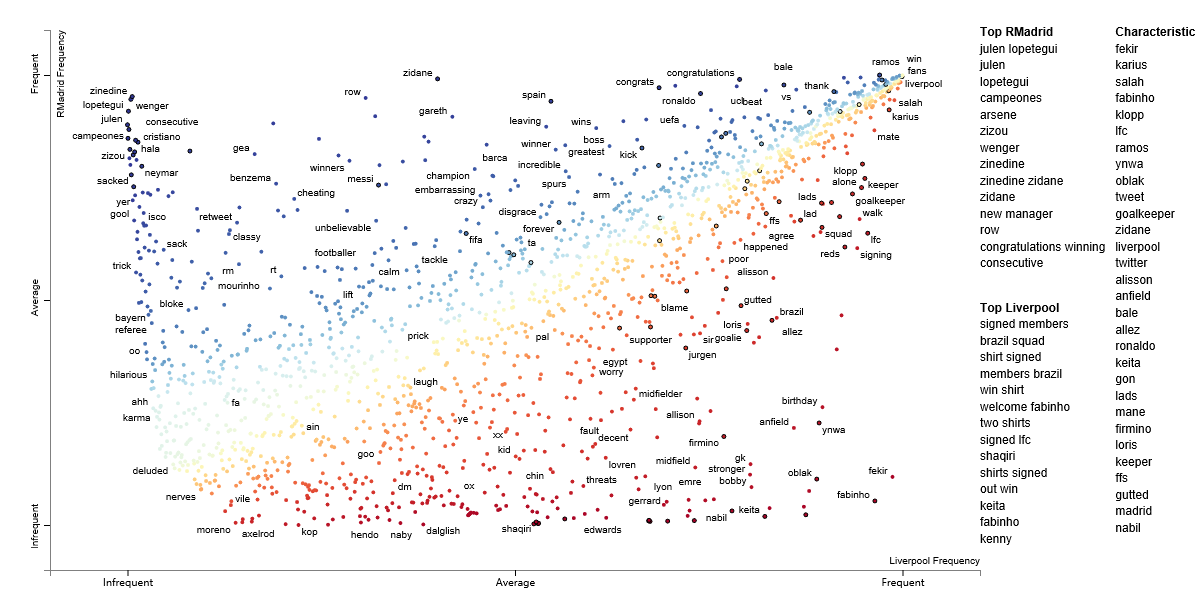

In [29]:
from IPython.display import Image
Image(filename='RMadrid.png')